# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

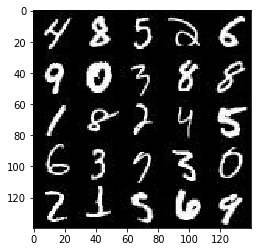

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

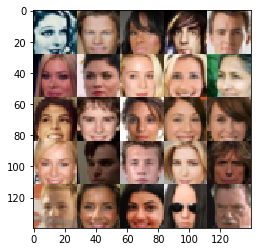

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_images=tf.placeholder(tf.float32,(None,image_width,image_height,image_channels),name="input_images")
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate=tf.placeholder(tf.float32,name='learning_rate')
    return input_images, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    
    leaky_relu = lambda x: tf.maximum(0.01 * x, x)
    
    def conv(inputs, filters, batch_norm=True):
        outputs = tf.layers.conv2d(inputs, filters, 5, 2, 'same')
        if batch_norm:
            outputs = tf.layers.batch_normalization(outputs, training=True)
        return leaky_relu(outputs)
        
    
    with tf.variable_scope("discriminator", reuse=reuse):
        # input 28*28*3
        x1 = conv(images, 64, batch_norm=False) # 14*14*64
        x2 = conv(x1, 128) # 7*7*128
        x3 = conv(x2, 256) # 4*4*256
        
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    leaky_relu = lambda x: tf.maximum(0.01 * x, x)
    with tf.variable_scope("generator", reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = leaky_relu(x1)
        # 7*7*512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, 1, 'SAME')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(x2)
        # 7*7*256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, 2, 'SAME')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = leaky_relu(x3)
        # 14*14*128
    
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, 2, 'SAME')
        out = tf.tanh(logits)
        # 28*28*out_channel_dim
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [15]:
import pickle as pkl
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])

    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                steps +=1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Batch {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)


    
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch 10... Discriminator Loss: 3.4107... Generator Loss: 0.1307
Epoch 1/2... Batch 20... Discriminator Loss: 1.2587... Generator Loss: 2.4676
Epoch 1/2... Batch 30... Discriminator Loss: 0.9641... Generator Loss: 1.9772
Epoch 1/2... Batch 40... Discriminator Loss: 0.9351... Generator Loss: 2.2842
Epoch 1/2... Batch 50... Discriminator Loss: 0.5329... Generator Loss: 2.8401
Epoch 1/2... Batch 60... Discriminator Loss: 0.4365... Generator Loss: 4.2784
Epoch 1/2... Batch 70... Discriminator Loss: 0.5212... Generator Loss: 3.6257
Epoch 1/2... Batch 80... Discriminator Loss: 0.7679... Generator Loss: 1.5109
Epoch 1/2... Batch 90... Discriminator Loss: 1.0365... Generator Loss: 1.0838
Epoch 1/2... Batch 100... Discriminator Loss: 2.7813... Generator Loss: 0.1791


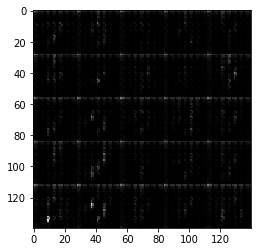

Epoch 1/2... Batch 110... Discriminator Loss: 1.2042... Generator Loss: 0.7761
Epoch 1/2... Batch 120... Discriminator Loss: 1.3611... Generator Loss: 2.2091
Epoch 1/2... Batch 130... Discriminator Loss: 1.3663... Generator Loss: 0.6240
Epoch 1/2... Batch 140... Discriminator Loss: 1.1475... Generator Loss: 0.8278
Epoch 1/2... Batch 150... Discriminator Loss: 1.1312... Generator Loss: 1.0027
Epoch 1/2... Batch 160... Discriminator Loss: 1.4779... Generator Loss: 1.4633
Epoch 1/2... Batch 170... Discriminator Loss: 1.6362... Generator Loss: 2.3322
Epoch 1/2... Batch 180... Discriminator Loss: 1.6668... Generator Loss: 0.3842
Epoch 1/2... Batch 190... Discriminator Loss: 1.2112... Generator Loss: 0.9363
Epoch 1/2... Batch 200... Discriminator Loss: 2.0083... Generator Loss: 3.0760


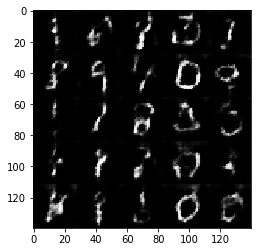

Epoch 1/2... Batch 210... Discriminator Loss: 1.2371... Generator Loss: 1.6825
Epoch 1/2... Batch 220... Discriminator Loss: 1.3805... Generator Loss: 1.7798
Epoch 1/2... Batch 230... Discriminator Loss: 1.2313... Generator Loss: 1.4843
Epoch 1/2... Batch 240... Discriminator Loss: 1.4771... Generator Loss: 0.4848
Epoch 1/2... Batch 250... Discriminator Loss: 1.2266... Generator Loss: 1.2714
Epoch 1/2... Batch 260... Discriminator Loss: 1.2526... Generator Loss: 0.6587
Epoch 1/2... Batch 270... Discriminator Loss: 1.2672... Generator Loss: 1.3952
Epoch 1/2... Batch 280... Discriminator Loss: 1.1918... Generator Loss: 1.5217
Epoch 1/2... Batch 290... Discriminator Loss: 1.2923... Generator Loss: 1.3965
Epoch 1/2... Batch 300... Discriminator Loss: 1.0903... Generator Loss: 1.0145


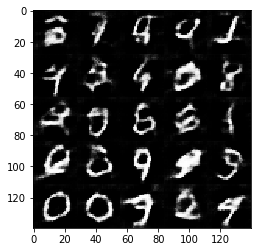

Epoch 1/2... Batch 310... Discriminator Loss: 1.3038... Generator Loss: 0.5912
Epoch 1/2... Batch 320... Discriminator Loss: 1.3471... Generator Loss: 1.5216
Epoch 1/2... Batch 330... Discriminator Loss: 1.2369... Generator Loss: 1.5687
Epoch 1/2... Batch 340... Discriminator Loss: 1.2506... Generator Loss: 1.9374
Epoch 1/2... Batch 350... Discriminator Loss: 1.2301... Generator Loss: 0.6828
Epoch 1/2... Batch 360... Discriminator Loss: 1.0404... Generator Loss: 1.0927
Epoch 1/2... Batch 370... Discriminator Loss: 1.5495... Generator Loss: 2.1283
Epoch 1/2... Batch 380... Discriminator Loss: 1.1653... Generator Loss: 1.1112
Epoch 1/2... Batch 390... Discriminator Loss: 1.1858... Generator Loss: 1.5834
Epoch 1/2... Batch 400... Discriminator Loss: 2.3007... Generator Loss: 3.2204


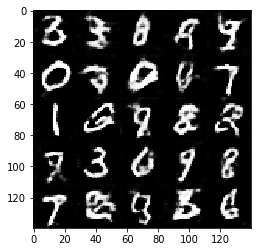

Epoch 1/2... Batch 410... Discriminator Loss: 1.2316... Generator Loss: 0.7934
Epoch 1/2... Batch 420... Discriminator Loss: 1.3391... Generator Loss: 0.6226
Epoch 1/2... Batch 430... Discriminator Loss: 1.3714... Generator Loss: 1.4642
Epoch 1/2... Batch 440... Discriminator Loss: 1.1111... Generator Loss: 1.3420
Epoch 1/2... Batch 450... Discriminator Loss: 1.1110... Generator Loss: 0.9861
Epoch 1/2... Batch 460... Discriminator Loss: 1.1877... Generator Loss: 0.7871
Epoch 2/2... Batch 10... Discriminator Loss: 1.2256... Generator Loss: 0.9138
Epoch 2/2... Batch 20... Discriminator Loss: 1.3261... Generator Loss: 0.6072
Epoch 2/2... Batch 30... Discriminator Loss: 1.0763... Generator Loss: 1.0305
Epoch 2/2... Batch 40... Discriminator Loss: 1.2721... Generator Loss: 0.6821
Epoch 2/2... Batch 50... Discriminator Loss: 1.6171... Generator Loss: 0.3969
Epoch 2/2... Batch 60... Discriminator Loss: 1.1626... Generator Loss: 1.5708
Epoch 2/2... Batch 70... Discriminator Loss: 1.1061... Gen

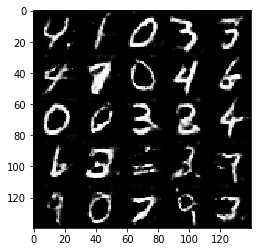

Epoch 2/2... Batch 110... Discriminator Loss: 1.3126... Generator Loss: 0.6313
Epoch 2/2... Batch 120... Discriminator Loss: 1.4321... Generator Loss: 0.4981
Epoch 2/2... Batch 130... Discriminator Loss: 1.0840... Generator Loss: 1.0303
Epoch 2/2... Batch 140... Discriminator Loss: 1.2275... Generator Loss: 0.7557
Epoch 2/2... Batch 150... Discriminator Loss: 1.1215... Generator Loss: 0.9896
Epoch 2/2... Batch 160... Discriminator Loss: 1.3504... Generator Loss: 0.6208
Epoch 2/2... Batch 170... Discriminator Loss: 1.2490... Generator Loss: 0.7252
Epoch 2/2... Batch 180... Discriminator Loss: 1.2891... Generator Loss: 1.6864
Epoch 2/2... Batch 190... Discriminator Loss: 1.6489... Generator Loss: 0.3926
Epoch 2/2... Batch 200... Discriminator Loss: 1.1838... Generator Loss: 0.7957


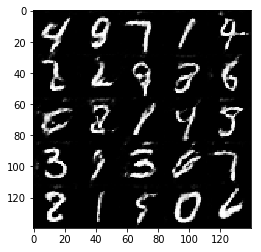

Epoch 2/2... Batch 210... Discriminator Loss: 1.6584... Generator Loss: 0.3679
Epoch 2/2... Batch 220... Discriminator Loss: 1.1420... Generator Loss: 1.1565
Epoch 2/2... Batch 230... Discriminator Loss: 1.6432... Generator Loss: 0.3956
Epoch 2/2... Batch 240... Discriminator Loss: 1.2346... Generator Loss: 0.8839
Epoch 2/2... Batch 250... Discriminator Loss: 1.2807... Generator Loss: 0.7731
Epoch 2/2... Batch 260... Discriminator Loss: 1.1685... Generator Loss: 1.3682
Epoch 2/2... Batch 270... Discriminator Loss: 1.8381... Generator Loss: 0.3002
Epoch 2/2... Batch 280... Discriminator Loss: 1.4705... Generator Loss: 0.4943
Epoch 2/2... Batch 290... Discriminator Loss: 1.3820... Generator Loss: 0.5446
Epoch 2/2... Batch 300... Discriminator Loss: 1.1596... Generator Loss: 0.8113


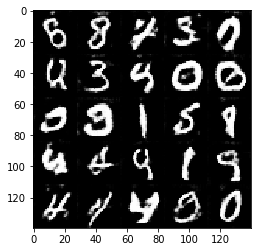

Epoch 2/2... Batch 310... Discriminator Loss: 1.2476... Generator Loss: 0.7352
Epoch 2/2... Batch 320... Discriminator Loss: 1.4500... Generator Loss: 0.5080
Epoch 2/2... Batch 330... Discriminator Loss: 1.2153... Generator Loss: 0.9435
Epoch 2/2... Batch 340... Discriminator Loss: 1.1167... Generator Loss: 1.0221
Epoch 2/2... Batch 350... Discriminator Loss: 1.4373... Generator Loss: 0.4796
Epoch 2/2... Batch 360... Discriminator Loss: 1.2192... Generator Loss: 1.9066
Epoch 2/2... Batch 370... Discriminator Loss: 1.1655... Generator Loss: 1.2432
Epoch 2/2... Batch 380... Discriminator Loss: 1.3837... Generator Loss: 0.5966
Epoch 2/2... Batch 390... Discriminator Loss: 1.2504... Generator Loss: 0.6573
Epoch 2/2... Batch 400... Discriminator Loss: 1.0890... Generator Loss: 1.2315


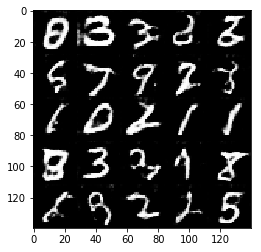

Epoch 2/2... Batch 410... Discriminator Loss: 1.2581... Generator Loss: 0.9069
Epoch 2/2... Batch 420... Discriminator Loss: 1.3213... Generator Loss: 1.2904
Epoch 2/2... Batch 430... Discriminator Loss: 1.0794... Generator Loss: 1.0371
Epoch 2/2... Batch 440... Discriminator Loss: 1.1709... Generator Loss: 1.5976
Epoch 2/2... Batch 450... Discriminator Loss: 1.6854... Generator Loss: 0.3621
Epoch 2/2... Batch 460... Discriminator Loss: 1.0533... Generator Loss: 1.0812


In [16]:
batch_size = 128
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch 10... Discriminator Loss: 1.0867... Generator Loss: 1.1402
Epoch 1/1... Batch 20... Discriminator Loss: 0.6569... Generator Loss: 3.8707
Epoch 1/1... Batch 30... Discriminator Loss: 0.8107... Generator Loss: 7.5951
Epoch 1/1... Batch 40... Discriminator Loss: 0.4973... Generator Loss: 3.4812
Epoch 1/1... Batch 50... Discriminator Loss: 1.6211... Generator Loss: 0.3855
Epoch 1/1... Batch 60... Discriminator Loss: 0.8001... Generator Loss: 2.9396
Epoch 1/1... Batch 70... Discriminator Loss: 1.0979... Generator Loss: 1.3531
Epoch 1/1... Batch 80... Discriminator Loss: 0.7358... Generator Loss: 2.1470
Epoch 1/1... Batch 90... Discriminator Loss: 1.0320... Generator Loss: 1.1894
Epoch 1/1... Batch 100... Discriminator Loss: 0.9050... Generator Loss: 1.5251


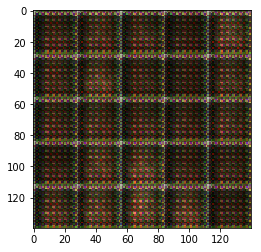

Epoch 1/1... Batch 110... Discriminator Loss: 0.8566... Generator Loss: 1.6388
Epoch 1/1... Batch 120... Discriminator Loss: 0.9352... Generator Loss: 1.9159
Epoch 1/1... Batch 130... Discriminator Loss: 0.9044... Generator Loss: 2.4681
Epoch 1/1... Batch 140... Discriminator Loss: 1.0451... Generator Loss: 1.5137
Epoch 1/1... Batch 150... Discriminator Loss: 1.1188... Generator Loss: 0.8274
Epoch 1/1... Batch 160... Discriminator Loss: 1.2548... Generator Loss: 1.9711
Epoch 1/1... Batch 170... Discriminator Loss: 1.0320... Generator Loss: 1.2468
Epoch 1/1... Batch 180... Discriminator Loss: 1.1425... Generator Loss: 0.8629
Epoch 1/1... Batch 190... Discriminator Loss: 1.0519... Generator Loss: 1.0732
Epoch 1/1... Batch 200... Discriminator Loss: 1.2657... Generator Loss: 0.9474


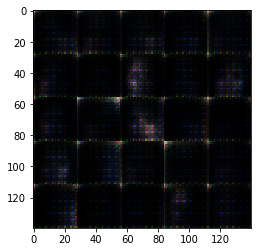

Epoch 1/1... Batch 210... Discriminator Loss: 1.2579... Generator Loss: 1.9704
Epoch 1/1... Batch 220... Discriminator Loss: 0.9763... Generator Loss: 2.0066
Epoch 1/1... Batch 230... Discriminator Loss: 1.1430... Generator Loss: 0.8513
Epoch 1/1... Batch 240... Discriminator Loss: 0.8969... Generator Loss: 1.6413
Epoch 1/1... Batch 250... Discriminator Loss: 0.9774... Generator Loss: 1.2419
Epoch 1/1... Batch 260... Discriminator Loss: 1.1049... Generator Loss: 1.5269
Epoch 1/1... Batch 270... Discriminator Loss: 1.7465... Generator Loss: 0.3832
Epoch 1/1... Batch 280... Discriminator Loss: 1.0013... Generator Loss: 1.2544
Epoch 1/1... Batch 290... Discriminator Loss: 1.0374... Generator Loss: 2.1820
Epoch 1/1... Batch 300... Discriminator Loss: 0.8597... Generator Loss: 2.0034


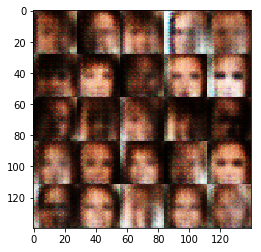

Epoch 1/1... Batch 310... Discriminator Loss: 1.0827... Generator Loss: 1.1107
Epoch 1/1... Batch 320... Discriminator Loss: 1.5126... Generator Loss: 0.4923
Epoch 1/1... Batch 330... Discriminator Loss: 1.3672... Generator Loss: 1.8617
Epoch 1/1... Batch 340... Discriminator Loss: 1.1572... Generator Loss: 0.8940
Epoch 1/1... Batch 350... Discriminator Loss: 1.0827... Generator Loss: 1.8893
Epoch 1/1... Batch 360... Discriminator Loss: 1.2213... Generator Loss: 1.7722
Epoch 1/1... Batch 370... Discriminator Loss: 1.1953... Generator Loss: 1.8368
Epoch 1/1... Batch 380... Discriminator Loss: 1.2406... Generator Loss: 2.0823
Epoch 1/1... Batch 390... Discriminator Loss: 1.1277... Generator Loss: 1.2249
Epoch 1/1... Batch 400... Discriminator Loss: 1.0250... Generator Loss: 1.1725


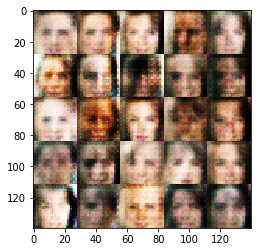

Epoch 1/1... Batch 410... Discriminator Loss: 1.2628... Generator Loss: 1.9926
Epoch 1/1... Batch 420... Discriminator Loss: 1.1210... Generator Loss: 0.9963
Epoch 1/1... Batch 430... Discriminator Loss: 1.2587... Generator Loss: 1.1874
Epoch 1/1... Batch 440... Discriminator Loss: 1.3603... Generator Loss: 0.9769
Epoch 1/1... Batch 450... Discriminator Loss: 1.1501... Generator Loss: 1.2759
Epoch 1/1... Batch 460... Discriminator Loss: 1.1698... Generator Loss: 1.0654
Epoch 1/1... Batch 470... Discriminator Loss: 1.2868... Generator Loss: 1.2611
Epoch 1/1... Batch 480... Discriminator Loss: 1.2014... Generator Loss: 1.1272
Epoch 1/1... Batch 490... Discriminator Loss: 1.2157... Generator Loss: 0.9636
Epoch 1/1... Batch 500... Discriminator Loss: 1.2990... Generator Loss: 0.7066


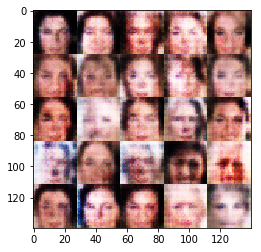

Epoch 1/1... Batch 510... Discriminator Loss: 1.3375... Generator Loss: 0.8546
Epoch 1/1... Batch 520... Discriminator Loss: 1.3275... Generator Loss: 0.6817
Epoch 1/1... Batch 530... Discriminator Loss: 1.2443... Generator Loss: 0.8063
Epoch 1/1... Batch 540... Discriminator Loss: 1.1422... Generator Loss: 1.1694
Epoch 1/1... Batch 550... Discriminator Loss: 1.2534... Generator Loss: 1.7447
Epoch 1/1... Batch 560... Discriminator Loss: 1.1672... Generator Loss: 0.8498
Epoch 1/1... Batch 570... Discriminator Loss: 1.1008... Generator Loss: 1.1271
Epoch 1/1... Batch 580... Discriminator Loss: 1.1751... Generator Loss: 0.8026
Epoch 1/1... Batch 590... Discriminator Loss: 1.0992... Generator Loss: 1.0623
Epoch 1/1... Batch 600... Discriminator Loss: 1.1398... Generator Loss: 0.7650


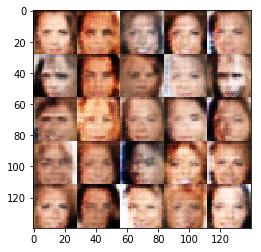

Epoch 1/1... Batch 610... Discriminator Loss: 1.1258... Generator Loss: 1.0414
Epoch 1/1... Batch 620... Discriminator Loss: 1.2204... Generator Loss: 1.2123
Epoch 1/1... Batch 630... Discriminator Loss: 1.2888... Generator Loss: 1.0951
Epoch 1/1... Batch 640... Discriminator Loss: 1.3151... Generator Loss: 0.8195
Epoch 1/1... Batch 650... Discriminator Loss: 1.3099... Generator Loss: 0.6099
Epoch 1/1... Batch 660... Discriminator Loss: 1.0859... Generator Loss: 1.2452
Epoch 1/1... Batch 670... Discriminator Loss: 1.6140... Generator Loss: 2.5194
Epoch 1/1... Batch 680... Discriminator Loss: 1.4169... Generator Loss: 0.5080
Epoch 1/1... Batch 690... Discriminator Loss: 1.1922... Generator Loss: 0.8483
Epoch 1/1... Batch 700... Discriminator Loss: 1.0708... Generator Loss: 1.5584


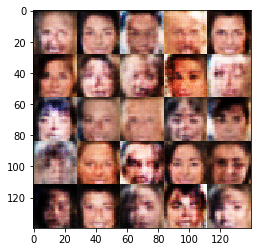

Epoch 1/1... Batch 710... Discriminator Loss: 1.3343... Generator Loss: 1.2740
Epoch 1/1... Batch 720... Discriminator Loss: 1.3775... Generator Loss: 0.5391
Epoch 1/1... Batch 730... Discriminator Loss: 1.1832... Generator Loss: 1.1493
Epoch 1/1... Batch 740... Discriminator Loss: 1.4029... Generator Loss: 0.5338
Epoch 1/1... Batch 750... Discriminator Loss: 1.9361... Generator Loss: 0.2755
Epoch 1/1... Batch 760... Discriminator Loss: 1.1251... Generator Loss: 1.1788
Epoch 1/1... Batch 770... Discriminator Loss: 0.9633... Generator Loss: 1.0224
Epoch 1/1... Batch 780... Discriminator Loss: 1.2176... Generator Loss: 0.9833
Epoch 1/1... Batch 790... Discriminator Loss: 1.3464... Generator Loss: 0.5478
Epoch 1/1... Batch 800... Discriminator Loss: 0.7107... Generator Loss: 1.6991


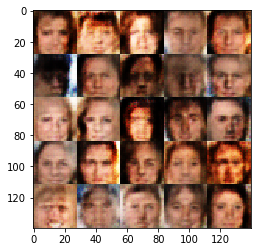

Epoch 1/1... Batch 810... Discriminator Loss: 1.0412... Generator Loss: 1.0374
Epoch 1/1... Batch 820... Discriminator Loss: 1.1830... Generator Loss: 0.7795
Epoch 1/1... Batch 830... Discriminator Loss: 0.7196... Generator Loss: 1.8462
Epoch 1/1... Batch 840... Discriminator Loss: 1.3987... Generator Loss: 0.6835
Epoch 1/1... Batch 850... Discriminator Loss: 1.3467... Generator Loss: 0.5968
Epoch 1/1... Batch 860... Discriminator Loss: 1.6664... Generator Loss: 0.3745
Epoch 1/1... Batch 870... Discriminator Loss: 1.1554... Generator Loss: 1.2040
Epoch 1/1... Batch 880... Discriminator Loss: 0.8560... Generator Loss: 1.2026
Epoch 1/1... Batch 890... Discriminator Loss: 0.9973... Generator Loss: 3.5022
Epoch 1/1... Batch 900... Discriminator Loss: 1.7510... Generator Loss: 0.3142


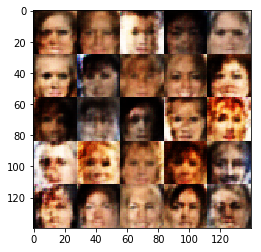

Epoch 1/1... Batch 910... Discriminator Loss: 1.0569... Generator Loss: 1.0277
Epoch 1/1... Batch 920... Discriminator Loss: 0.9234... Generator Loss: 1.1338
Epoch 1/1... Batch 930... Discriminator Loss: 1.5591... Generator Loss: 0.4035
Epoch 1/1... Batch 940... Discriminator Loss: 1.2141... Generator Loss: 0.7299
Epoch 1/1... Batch 950... Discriminator Loss: 1.1636... Generator Loss: 0.9581
Epoch 1/1... Batch 960... Discriminator Loss: 1.0652... Generator Loss: 0.9069
Epoch 1/1... Batch 970... Discriminator Loss: 1.1065... Generator Loss: 0.9659
Epoch 1/1... Batch 980... Discriminator Loss: 0.6967... Generator Loss: 1.9484
Epoch 1/1... Batch 990... Discriminator Loss: 0.9648... Generator Loss: 1.5064
Epoch 1/1... Batch 1000... Discriminator Loss: 1.0855... Generator Loss: 1.1754


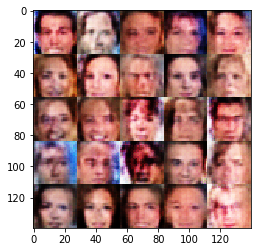

Epoch 1/1... Batch 1010... Discriminator Loss: 1.3293... Generator Loss: 1.5804
Epoch 1/1... Batch 1020... Discriminator Loss: 1.0522... Generator Loss: 1.2282
Epoch 1/1... Batch 1030... Discriminator Loss: 1.2573... Generator Loss: 1.7317
Epoch 1/1... Batch 1040... Discriminator Loss: 1.2992... Generator Loss: 0.7386
Epoch 1/1... Batch 1050... Discriminator Loss: 0.9208... Generator Loss: 1.4946
Epoch 1/1... Batch 1060... Discriminator Loss: 1.0852... Generator Loss: 1.4347
Epoch 1/1... Batch 1070... Discriminator Loss: 1.1896... Generator Loss: 0.8663
Epoch 1/1... Batch 1080... Discriminator Loss: 1.2381... Generator Loss: 0.6496
Epoch 1/1... Batch 1090... Discriminator Loss: 1.2014... Generator Loss: 0.6443
Epoch 1/1... Batch 1100... Discriminator Loss: 1.6183... Generator Loss: 0.4211


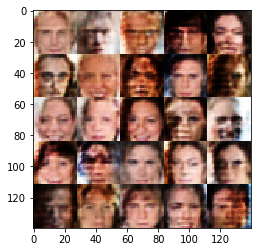

Epoch 1/1... Batch 1110... Discriminator Loss: 1.8977... Generator Loss: 2.0597
Epoch 1/1... Batch 1120... Discriminator Loss: 1.0906... Generator Loss: 0.9844
Epoch 1/1... Batch 1130... Discriminator Loss: 1.2819... Generator Loss: 0.6234
Epoch 1/1... Batch 1140... Discriminator Loss: 0.7808... Generator Loss: 1.7232
Epoch 1/1... Batch 1150... Discriminator Loss: 1.6807... Generator Loss: 0.3975
Epoch 1/1... Batch 1160... Discriminator Loss: 1.2819... Generator Loss: 0.7268
Epoch 1/1... Batch 1170... Discriminator Loss: 1.3969... Generator Loss: 0.5208
Epoch 1/1... Batch 1180... Discriminator Loss: 0.9843... Generator Loss: 0.9173
Epoch 1/1... Batch 1190... Discriminator Loss: 1.3079... Generator Loss: 0.6202
Epoch 1/1... Batch 1200... Discriminator Loss: 0.9548... Generator Loss: 0.9254


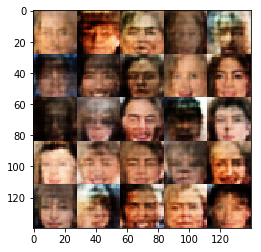

Epoch 1/1... Batch 1210... Discriminator Loss: 1.1592... Generator Loss: 0.7641
Epoch 1/1... Batch 1220... Discriminator Loss: 0.8324... Generator Loss: 1.7887
Epoch 1/1... Batch 1230... Discriminator Loss: 1.1332... Generator Loss: 1.0868
Epoch 1/1... Batch 1240... Discriminator Loss: 2.1347... Generator Loss: 0.2151
Epoch 1/1... Batch 1250... Discriminator Loss: 1.1249... Generator Loss: 0.9998
Epoch 1/1... Batch 1260... Discriminator Loss: 0.8024... Generator Loss: 1.4780
Epoch 1/1... Batch 1270... Discriminator Loss: 1.2378... Generator Loss: 1.8913
Epoch 1/1... Batch 1280... Discriminator Loss: 0.9102... Generator Loss: 3.2807
Epoch 1/1... Batch 1290... Discriminator Loss: 0.9462... Generator Loss: 1.7373
Epoch 1/1... Batch 1300... Discriminator Loss: 0.9843... Generator Loss: 1.3314


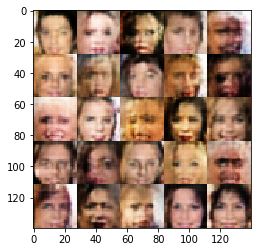

Epoch 1/1... Batch 1310... Discriminator Loss: 1.7168... Generator Loss: 0.3349
Epoch 1/1... Batch 1320... Discriminator Loss: 0.9142... Generator Loss: 0.9863
Epoch 1/1... Batch 1330... Discriminator Loss: 1.2515... Generator Loss: 0.9004
Epoch 1/1... Batch 1340... Discriminator Loss: 1.1150... Generator Loss: 0.6980
Epoch 1/1... Batch 1350... Discriminator Loss: 1.0616... Generator Loss: 0.7467
Epoch 1/1... Batch 1360... Discriminator Loss: 1.2170... Generator Loss: 1.3151
Epoch 1/1... Batch 1370... Discriminator Loss: 1.8266... Generator Loss: 0.3022
Epoch 1/1... Batch 1380... Discriminator Loss: 0.8726... Generator Loss: 1.4625
Epoch 1/1... Batch 1390... Discriminator Loss: 1.1955... Generator Loss: 1.0086
Epoch 1/1... Batch 1400... Discriminator Loss: 1.0693... Generator Loss: 1.0609


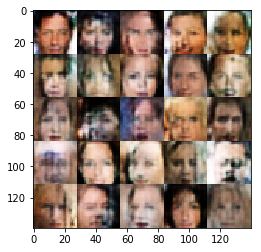

Epoch 1/1... Batch 1410... Discriminator Loss: 0.9561... Generator Loss: 1.0689
Epoch 1/1... Batch 1420... Discriminator Loss: 0.6265... Generator Loss: 1.8509
Epoch 1/1... Batch 1430... Discriminator Loss: 1.0057... Generator Loss: 1.9245
Epoch 1/1... Batch 1440... Discriminator Loss: 1.3449... Generator Loss: 3.2269
Epoch 1/1... Batch 1450... Discriminator Loss: 1.1084... Generator Loss: 0.7382
Epoch 1/1... Batch 1460... Discriminator Loss: 1.1815... Generator Loss: 2.0848
Epoch 1/1... Batch 1470... Discriminator Loss: 1.0815... Generator Loss: 0.8605
Epoch 1/1... Batch 1480... Discriminator Loss: 0.6327... Generator Loss: 1.5500
Epoch 1/1... Batch 1490... Discriminator Loss: 1.3200... Generator Loss: 0.5800
Epoch 1/1... Batch 1500... Discriminator Loss: 0.8215... Generator Loss: 1.5036


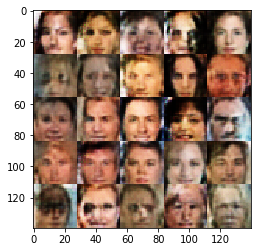

Epoch 1/1... Batch 1510... Discriminator Loss: 1.1503... Generator Loss: 0.8689
Epoch 1/1... Batch 1520... Discriminator Loss: 1.4584... Generator Loss: 0.4805
Epoch 1/1... Batch 1530... Discriminator Loss: 0.8198... Generator Loss: 1.7025
Epoch 1/1... Batch 1540... Discriminator Loss: 1.0142... Generator Loss: 1.3212
Epoch 1/1... Batch 1550... Discriminator Loss: 1.4345... Generator Loss: 0.4674
Epoch 1/1... Batch 1560... Discriminator Loss: 1.1331... Generator Loss: 1.5795
Epoch 1/1... Batch 1570... Discriminator Loss: 0.9846... Generator Loss: 1.7545
Epoch 1/1... Batch 1580... Discriminator Loss: 0.9968... Generator Loss: 1.0133


In [17]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.